In [1]:
%load_ext autoreload
%autoreload 2

import jax.numpy as jnp
from jax import grad, jit, value_and_grad, make_jaxpr, config
from jax import random, profiler, config, debug
from jax.nn import sigmoid
import numpy as np
import jax
import optax

from larndsim.sim_jax import load_data, set_pixel_plane, chop_tracks, load_params, prepare_tracks, simulate, params_loss, id2pixel, get_pixel_coordinates

from numpy.lib import recfunctions as rfn

import matplotlib.pyplot as plt
from tqdm import tqdm
import h5py

jax.config.update('jax_platform_name', 'cpu')
config.update("jax_debug_nans", False)
plt.rcParams['font.size'] = 15

In [2]:
#Loading the tracks

ref_params = load_params()
# tracks_file = '/home/pgranger/larnd-sim/jit_version/larnd-sim/examples/module0_corsika.h5'
tracks_file = '/home/pgranger/larnd-sim/tools/evd/data/single_track.h5'
tracks, fields, original_tracks = prepare_tracks(ref_params, tracks_file)
print("Finished loading the tracks")

# to_propagate = ("Ab", "kb", "lifetime", "tran_diff", "long_diff")

ref, pixels_ref = simulate(ref_params, tracks, fields)
# signals, pix_renumbering, wfs, start_ticks = simulate(ref_params, tracks, fields)

def load_ref_results():
    # fname = "/home/pgranger/larnd-sim/tools/evd/data/result_legacy_nonoise.h5"
    fname = "/home/pgranger/larnd-sim/jit_version/larnd-sim/single_track_output.h5"
    with h5py.File(fname, 'r') as f:
        pixels = np.array(f['pixels'])
        adc = np.array(f['adc'])
        signals = np.array(f['signals'])
    return pixels, signals, adc

ref_pixels, ref_signals, ref_adc = load_ref_results()
ref_coords = get_pixel_coordinates(ref_params, ref_pixels[:, 0], ref_pixels[:, 1], np.zeros(ref_adc.shape[0]))

Finished loading the tracks


In [3]:
#Running some fit

to_propagate = ("Ab", "kb", "lifetime")
history = []

niter = 1000

modified_params = {
    'Ab': 0.5,
    'kb': 0.0786,
    "lifetime": 5e3,
    # "tran_diff": ref_params.tran_diff*1.1,
    # "long_diff": ref_params.long_diff*0.9
    # "tran_diff": 6e-6
}

params = ref_params.replace(**modified_params)
lr = 1e-2

params_normalization = params.replace()

norm_params = params.replace(**{key: 1. for key in to_propagate})

optimizer = optax.adam(lr)
opt_state = optimizer.init(norm_params)

# with jax.profiler.trace("/tmp/tensorboard"):
for i in tqdm(range(niter)):
    history.append(params)
    # for p in to_propagate:
    #     print(getattr(params, p))
    # value = params_loss(params, ref, pixels_ref, tracks, fields)
    # print("Loss is:", value)
    # grads = grad(params_loss, (0))(params, ref, pixels_ref, tracks, fields)
    loss_val, grads = value_and_grad(params_loss, (0))(params, ref, pixels_ref, tracks, fields)
    # print(value)
    # print(grads.Ab, grads.kb, grads.lifetime, grads.tran_diff, grads.long_diff)
    updates, opt_state = optimizer.update(grads, opt_state)
    norm_params = optax.apply_updates(norm_params, updates)
    params = norm_params.replace(**{key: getattr(norm_params, key)*getattr(params_normalization, key) for key in to_propagate})
    # max_radius = get_max_radius(params)
    # if max_radius != params.max_radius:
    #     params = params.replace(max_radius=max_radius)
    #     neighbors_sp = get_neighboring_pixels_sp(params, active_pixels_sp)
    # print(loss_val)
flat_history = {}
for key in to_propagate:
    flat_history[key] = [getattr(par, key) for par in history]
#Compute the max radius at the beginning from all the tracks
#Eventually adapt it some parameters change by more than ...

100%|██████████| 500/500 [01:22<00:00,  6.08it/s]


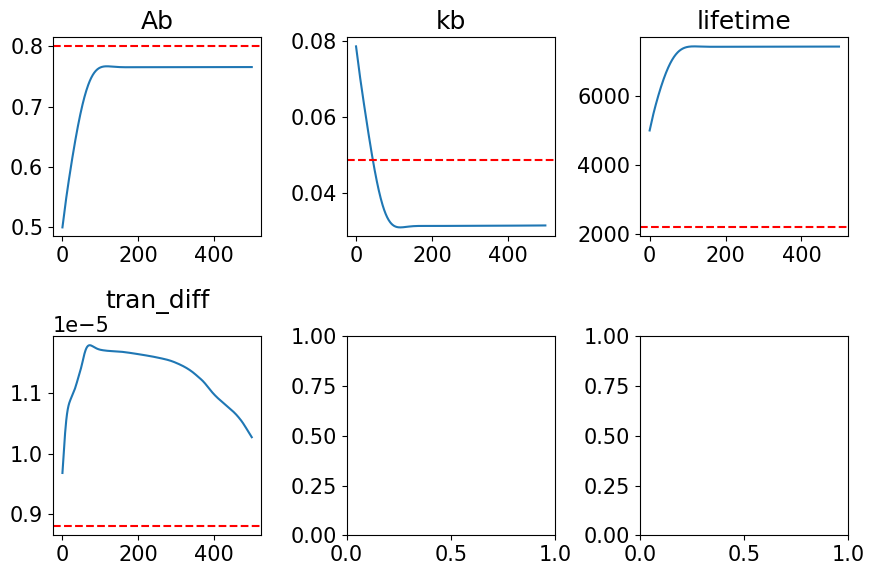

In [4]:
#Plotting of the fits
nrows, ncols = 2, 3
fig, axs = plt.subplots(nrows, ncols, figsize=(3*ncols, 3*nrows))

for it, key in enumerate(to_propagate):
    i = it//ncols
    j = it%ncols

    ax = axs[i, j]
    ax.plot(flat_history[key])
    ax.axhline(getattr(ref_params, key), linestyle='dashed', color='red')
    ax.set_title(key)
fig.tight_layout()

# Debugging

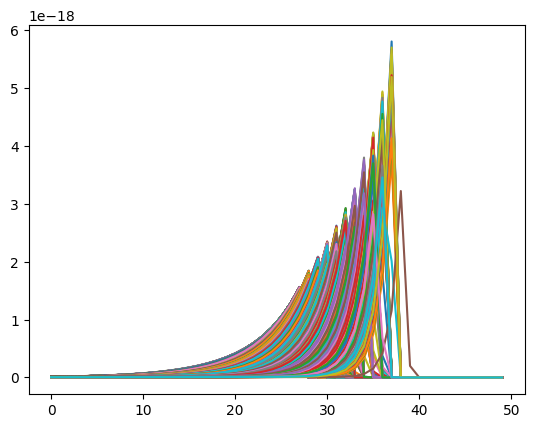

In [4]:
plt.plot(signals[pix_renumbering == 1].T);


(50.0, 150.0)

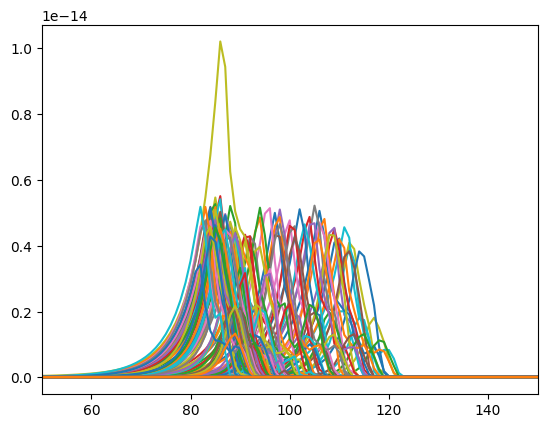

In [5]:
plt.plot(ref_signals.T);
plt.xlim(50, 150)

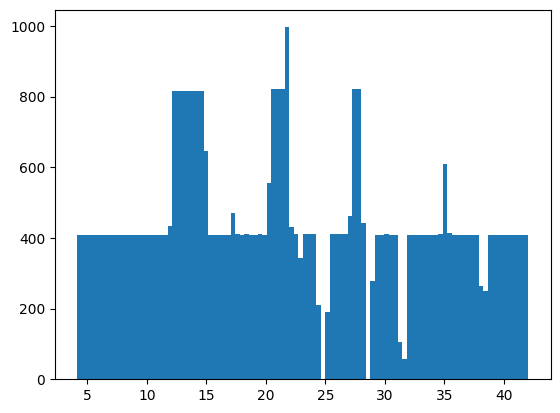

In [7]:
plt.hist(tracks[:, fields.index("y")], bins=100);

In [37]:
from larndsim.fee_jax import get_adc_values
# Testing the digitization
signal = np.arange(0, 1000)
signal[signal < 100] = 0
signal[signal > 900] = 0
signal[signal > 0] = 1

signal = jnp.array(signal)
signal = signal.reshape((1, 1000))

integral, ticks = get_adc_values(ref_params, signal)

print(integral)

[[80.100006  0.        0.        0.        0.        0.        0.
   0.        0.        0.      ]]


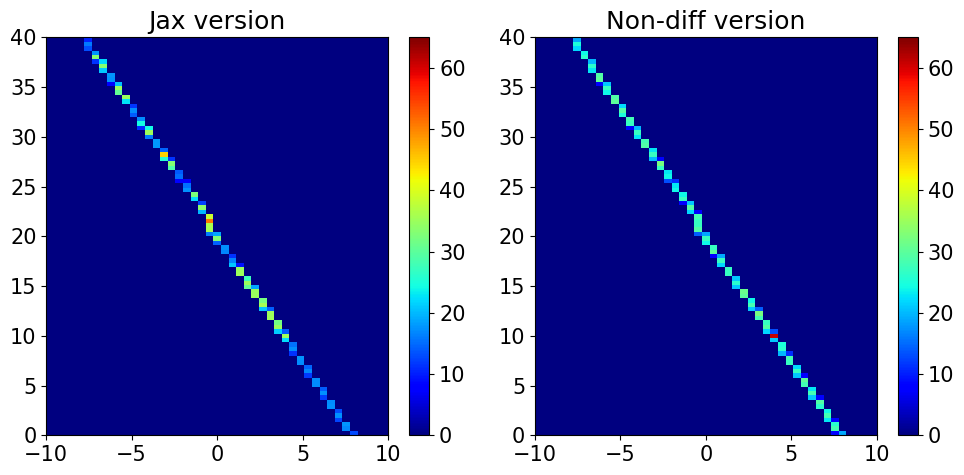

<Figure size 640x480 with 0 Axes>

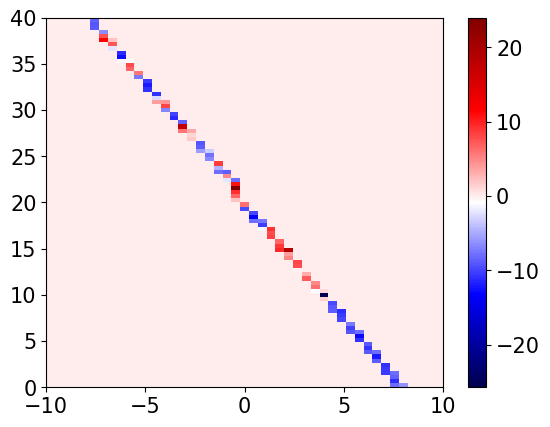

In [27]:
xpitch, ypitch, plane, eid = id2pixel(ref_params, pixels_ref)
pixels_coord = get_pixel_coordinates(ref_params, xpitch, ypitch, plane)

xbins = np.linspace(ref_params.tpc_borders[0][0][0], ref_params.tpc_borders[0][0][1], ref_params.n_pixels[0] + 1)
ybins = np.linspace(ref_params.tpc_borders[0][1][0], ref_params.tpc_borders[0][1][1], ref_params.n_pixels[1] + 1)

xbins = np.linspace(-10, 10, int(np.ceil(20./ref_params.pixel_pitch)))
ybins = np.linspace(0, 40, int(np.ceil(40./ref_params.pixel_pitch)))
vmin = 0
vmax = 65

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

h1, _, _, im = axs[0].hist2d(pixels_coord[:, 0], pixels_coord[:, 1], weights=ref[:, 0] - jnp.min(ref[:, 0]), bins=(xbins, ybins), vmin=vmin, vmax=vmax, cmap='jet');
# jax_bins, _, _, _ = plt.hist2d(pixels_coord[:, 0], pixels_coord[:, 1], weights=np.max(ref, axis=1), bins=(xbins, ybins));
# plt.hist2d(ref[:, fields.index("x")], ref[:, fields.index("y")], weights=ref[:, fields.index("n_electrons")], bins=(xbins, ybins));
fig.colorbar(im, ax=axs[0])
# plt.figure()
# # plt.hist2d(xpitch[plane == 0], ypitch[plane == 0], bins=(ref_params.n_pixels[0], ref_params.n_pixels[1]));
plt.figure()
# # plt.hist2d(xpitch[plane == 1], ypitch[plane == 1], bins=(ref_params.n_pixels[0], ref_params.n_pixels[1]));
# plt.hist2d(tracks[:, fields.index('x')], tracks[:, fields.index('y')], bins=(xbins, ybins));
# plt.hist2d(ref_pixels[:, 0]*ref_params.pixel_pitch + ref_params.tpc_borders[0][0][0], ref_pixels[:, 1]*ref_params.pixel_pitch + ref_params.tpc_borders[0][1][0], weights=ref_adc[:, 0], bins=(xbins, ybins));
h2, xedges, yedges, _ = axs[1].hist2d(ref_coords[:, 0], ref_coords[:, 1], weights=ref_adc[:, 0]-74, bins=(xbins, ybins), vmin=vmin, vmax=vmax, cmap='jet');
# ref_bins, _, _, _ = plt.hist2d(ref_coords[:, 0], ref_coords[:, 1], weights=np.max(ref_signals, axis=1), bins=(xbins, ybins));
fig.colorbar(im, ax=axs[1])

axs[0].set_title('Jax version')
axs[1].set_title('Non-diff version')

fig.tight_layout()
fig.savefig('')

# plt.figure()
# plt.hist2d(tracks[:, fields.index('x')], tracks[:, fields.index('y')], weights=tracks[:, fields.index('dE')], bins=(xbins, ybins), norm='log');
# plt.colorbar()

# plt.figure()
# plt.hist2d(original_tracks[:, fields.index('x_end')], original_tracks[:, fields.index('y_end')], weights=original_tracks[:, fields.index('dE')], bins=(xbins, ybins));
# plt.colorbar()
plt.figure()
plt.pcolormesh(xedges, yedges, (h1 - h2).T, cmap='seismic');
plt.colorbar()

In [5]:
%timeit simulate(params, tracks, fields)

3.61 ms ± 8.66 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
make_jaxpr(tracks_current)(ref_params, pixels)

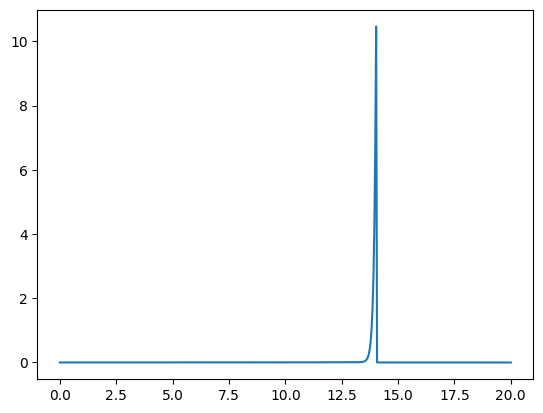

In [19]:
from larndsim.detsim_jax import current_model

t0 = 10
x = 0.4434/2
y = 0.4434/2
t = jnp.linspace(0, 20, 500)

current = current_model(t, t0, x, y)

plt.plot(t, current)

In [21]:
from jax.experimental.sparse import BCOO
import jax.numpy as jnp

size = 100000000000000

data = jnp.array([1., 3., 5.])
indices = jnp.array([[0],
                     [1],
                     [2]])
indices2 = jnp.array([[size - 10],
                     [size - 5000],
                     [size - 10000]])
mat = BCOO((data, indices), shape=(size,))
mat2 = BCOO((data, indices2), shape=(size,))
mat.update_layout()

BCOO(float32[100000000000000], nse=6)